# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Цель** - построить модель для задачи классификации, которая определит уйдёт клиент из банка или нет.

**Тип задачи** - классификация (бинарная классификация).

**Целевая метрика** - *F1*.

**Целевое значение метрики** *F1* - не менее 0.59 на тестовой выборке. 

## Описание данных
**Признаки**
- `RowNumber` - индекс строки в данных
- `CustomerId` - уникальный идентификатор клиента
- `Surname` - фамилия
- `CreditScore` - кредитный рейтинг
- `Geography` - страна проживания
- `Gender` - пол
- `Age` - возраст
- `Tenure` - сколько лет человек является клиентом банка
- `Balance` - баланс на счёте
- `NumOfProducts` - количество продуктов банка, используемых клиентом
- `HasCrCard` - наличие кредитной карты
- `IsActiveMember` - активность клиента
- `EstimatedSalary` - предполагаемая зарплата

**Целевой признак**
`Exited` - факт ухода клиента

## Импорт необходимых модулей
### Проверка наличия модуля `imblearn`

In [1]:
packages = !conda list 'imbalanced.*' --canonical;

if len(packages) == 1 and packages[-1] == '':
    print('Пакет "imbalanced-learn" не установлен.\nНачинаем установку.\n')
    !conda install -c conda-forge imbalanced-learn -y;
else:
    print(f'Пакет "imbalanced-learn" установлен.\n{packages[-1]}', sep='\n')

Пакет "imbalanced-learn" не установлен.
Начинаем установку.

Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/linux-64::jupyterhub==1.4.1=py39hf3d152e_0
done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.2
  latest version: 22.11.1

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - imbalanced-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.12.7  |       ha878542_0         143 KB  conda-forge
    certifi-2022.12.7          |     pyhd8ed1ab_0         147 KB  conda-forge
    imbalanced-learn-0.7.0     |             py_1          97 KB  conda-forge
    joblib-1.2.0               |     pyhd8ed1ab_0         205 KB  

### Проверка наличия модуля `category_encoders`

In [2]:
packages = !conda list 'category.*' --canonical;

if len(packages) == 1 and packages[-1] == '':
    print('Пакет "category_encoders" не установлен.\nНачинаем установку.\n')
    !conda install -c conda-forge category_encoders -y;
else:
    print(f'Пакет "category_encoders" установлен.\n{packages[-1]}', sep='\n')

Пакет "category_encoders" не установлен.
Начинаем установку.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.2
  latest version: 22.11.1

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - category_encoders


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    category_encoders-2.5.1.post0|     pyhd8ed1ab_0          62 KB  conda-forge
    libgcc-ng-12.2.0           |      h65d4601_19         931 KB  conda-forge
    libgomp-12.2.0             |      h65d4601_19         455 KB  conda-forge
    openssl-1.1.1s             |       h0b41bf4_1         1.9 MB  conda-forge
    patsy-0.5.3                |     pyhd8ed1ab_0         189 KB  conda-forge
    statsmodels-0.13.5         |   py39h2ae25f5_2        11.2 MB  conda-forge
    --------------

### Импорт

In [3]:
from category_encoders.count import CountEncoder

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd
from pandas.plotting import scatter_matrix

import seaborn as sns

from sklearn.compose import ColumnTransformer

from sklearn.dummy import DummyClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier


%matplotlib inline

## Загрузка данных и знакомство с ними
Откроем файл и выведем первые 10 строк таблицы.

In [4]:
try:
    data = pd.read_csv('/datasets/Churn.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')
    
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


Проверим типы данных, и наличие пропусков.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Столбец `Tenure` (сколько лет человек является клиентом банка) содержит пропуски. Вполне возможно, что данные пропуски являются результатом ошибки, очень маловероятно, что банк не имеет данных о том, сколько лет человек является его клиентом. В дальнейшем придётся сделать обработку пропусков.

Проверим наличие строк дубликатов

In [6]:
data.duplicated().any()

False

Дубликатов нет.

Проверим есть ли дисбаланс классов целевой переменной

In [7]:
data.Exited.value_counts(normalize=True).round(2)

0    0.8
1    0.2
Name: Exited, dtype: float64

Присутствует дисбаланс классов целевой переменной, поэтому при разделении на тестовую и тренировочную выборки будем использовать стратификацию. Чтобы снизить влияние дисбаланса на модель попробуем и сравним следующие приёмы:
1. взвешивание классов,
2. даунсемплинг,
3. апсемплинг.

## Формирование тестовой выборки
В переменную `X` копируем обучающие признаки, в переменную `y` копируем целевой признак.

In [8]:
X = data.drop(columns='Exited')
y = data.Exited.copy()

Разделим данные на тренировачный и тестовый наборы. Под тестовый набор выдлим 20% данных.

Чтобы получать воспроизводимые результаты будем использовать параметр `random_state` равным 42.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Чтобы сохранить максимально возможное количество данных для тренировки моделей, будем использовать технику крос-валидации (k-fold cross-validation) для подбора гиперпараметров и оценки метрик на тренировочной выборке. Таким образом, нет необходимости выделять валидационную выборку и тренировочного набора.

## Исследование данных

Столбцы RowNumber (индекс строки в данных) и CustomerId (уникальный идентификатор клиента) не несут смысловой нагрузки, поэтому отбросим их перед созданием модели.

Вычислим описательные статистки для тренировочного набора данных

In [10]:
X_train.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,8000.000000,8.000000e+03,8000.000000,8000.000000,7271.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,4990.432875,1.569088e+07,650.752500,38.946625,4.996012,76381.207499,1.529500,0.708750,0.514875,99730.811581
std,2896.482331,7.193619e+04,96.596432,10.526876,2.899056,62302.053597,0.581741,0.454367,0.499810,57335.116540
min,1.000000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000
25%,2461.750000,1.562869e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.000000,0.000000,50691.817500
50%,4987.500000,1.568995e+07,652.000000,37.000000,5.000000,97055.145000,1.000000,1.000000,1.000000,99446.940000
75%,7509.500000,1.575327e+07,717.000000,44.000000,8.000000,127633.195000,2.000000,1.000000,1.000000,148527.730000
max,10000.000000,1.581569e+07,850.000000,92.000000,10.000000,238387.560000,4.000000,1.000000,1.000000,199992.480000


Выведем гистограммы числовых переменных

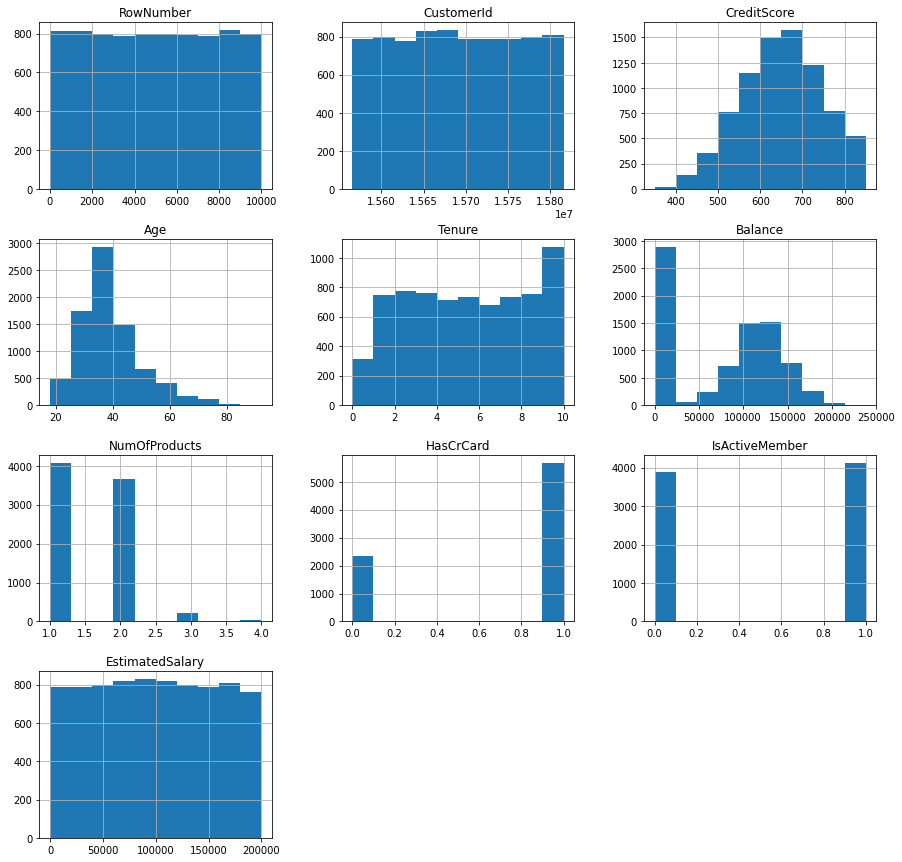

In [11]:
X_train.hist(figsize=(15,15))
plt.show()

Столбцы `RowNumber` и `CustomerId`, ожидаемо, имеют почти равномерное распределение. Распределение признака EstimatedSalary почему-то тоже близко к равномерному.

Признаки `HasCrCard` и `IsActiveMember` категориальные.

Количественные признаки имеют разные масштабы и формы распределений, поэтому будем использовать стандартизацию в процессе обработки.

Выведем описательные статистики для столбцов с типом `object`

In [12]:
X_train.describe(include='object')

,Surname,Geography,Gender
count,8000,8000,8000
unique,2620,3,2
top,Smith,France,Male
freq,26,3993,4387


Признак `Surname` (фамилия) содержит большое количество уникальных значений и, скорее всего, будет бесполезен. Отбросим его перед созданием модели.

Проверим наличик корреляции между количественными признаками

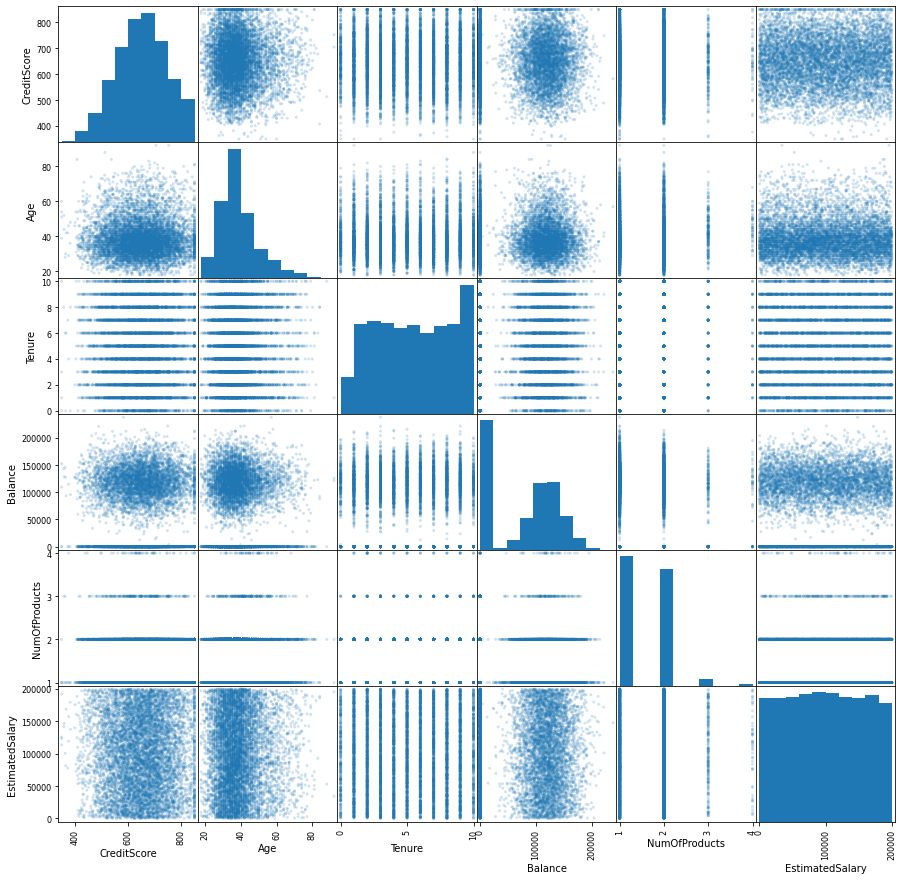

In [13]:
num_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scatter_matrix(X_train[num_columns],
               figsize=(15, 15),
               alpha=0.2
              )
plt.show()

Построим матрицу корреляции

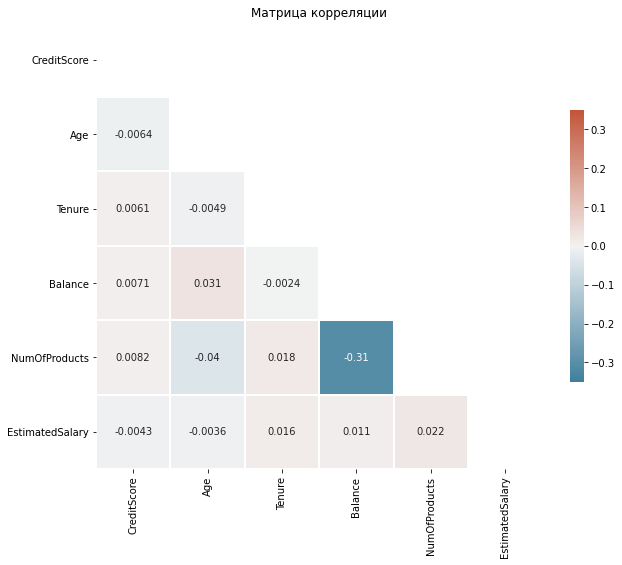

In [14]:
def plot_corr_matrix(df):
    corr = df.corr()
    
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    f, ax = plt.subplots(figsize=(10, 10))
    
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    sns.heatmap(corr,
                mask=mask,
                cmap=cmap,
                annot=True,
                vmax=0.35,
                vmin=-0.35,
                center=0.0,
                square=True,
                linewidths=1.0,
                cbar_kws={'shrink': 0.5},
                ax=ax
               )
    
    ax.set_title('Матрица корреляции')
    
    plt.show()
    
plot_corr_matrix(X_train[num_columns])

Наблюдается слабая отрицательная корреляция между признаками `Balance` и `NumOfProducts`. Между остальными признаками корреляция отсутствует.

## Базовая модель

Прежде чем приступить к разработке конвейра для обработки данных и моделей, напишем несколько функций, позволяющих быстро оценить модели.

In [15]:
def print_score(estimator, features, target, score='accuracy', cv=5, n_jobs=-1):
    '''Вычисляет среднее, минимальное и максимальное значения метрики,
    полученное с помощью кросс-валидации.
    '''
    
    scores = cross_val_score(estimator,
                             X=features,
                             y=target,
                             cv=cv,
                             scoring=score,
                             n_jobs=n_jobs,
                            )
    
    return pd.DataFrame(scores, columns=[score]).agg(['mean', 'min', 'max']).transpose()


def plot_roc_curve(y_train, y_scores, ax=None, style='', label=None):
    '''Выводит на экран кривую ROC.'''
    
    fpr, tpr, thresholds = roc_curve(y_train, y_scores)
    
    axes_flag = ax is None
    
    if axes_flag:
        fig, ax = plt.subplots(1, 1)
    
    ax.plot(fpr, tpr, style, label=label)
    
    if axes_flag:
        ax.plot([0,1], [0,1], 'k--', label='Random classifier')
        ax.grid()
        ax.set_xlim((0, 1))
        ax.set_ylim((0, 1))
        
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        
        ax.legend(loc='lower right')
        
        ax.set_title('ROC curve')
        return fig, ax
    
    return ax


def evaluate_model(model, X, y, label, method='predict_proba', n_jobs=-1):
    '''Выводит на экран сводку о производительности модели, состоящую из метрик
    accuracy, f1, roc_auc и кривую ROC.
    '''
    
    df = pd.DataFrame(columns= ['mean', 'min', 'max'])
    
    for metric in ['accuracy', 'f1', 'roc_auc']:
        df = pd.concat([df, print_score(model, X, y, score=metric, n_jobs=n_jobs)])
        
    print(f'Метрики для {label}')
    
    display(df)
    
    y_scores = cross_val_predict(model, X, y, cv=5, method=method, n_jobs=n_jobs)
    if method == 'predict_proba':
        y_scores = y_scores[:, -1]
        
    fig, ax = plot_roc_curve(y_train, y_scores, label=label)
    plt.show()

Сделаем базовую модель и оценим качество её предсказаний целевой переменной.

В качестве базовой модели выберем `DummyClassifier`, который будет предсказывать целевое значение случайным образом, при этом зададим параметр `strategy` равным `stratified`, чтобы распределение классов повторяло распределение в тренировочном наборе данных. 

Метрики для DummyClassifier


,mean,min,max
accuracy,0.679625,0.673750,0.690000
f1,0.206041,0.187097,0.218513
roc_auc,0.499686,0.493552,0.509462


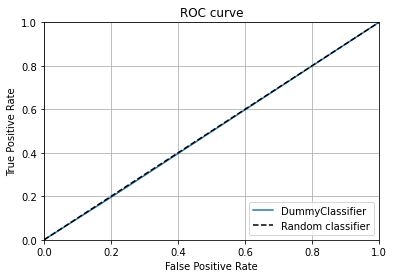

In [16]:
dummy_clf = DummyClassifier(strategy='stratified')

evaluate_model(model=dummy_clf, X=X_train, y=y_train, label='DummyClassifier')

Мы получили базовые значения метрик, теперь всякий раз создавая или дорабатывая модель мы можем сравнивать значения 
метрик новой модели с базовыми значениям. Если значения метрик новой модели будут близки к базовым - это будет сигналом, 
что с новой моделью что-то не так.

На графике `ROC curve` видно, что кривая классификатора проходит очень близко к пунктирной линии, проходящей через центр, поэтому далее на аналогичных графиках будем рисовать только пунктирную прямую, вместо того, чтобы вычислять её с помощью `DummyClassifier`.

## Подготовка данных

Напишем конвейер для подготовки данных.

В данных наблюдаются следующие проблемы:
1. Присутствуют бесполезные признаки: `Surname`, `RowNumber` и `CustomerId`. Устраним их с помощью `sklearn.compose.ColumnTransformer`.
2. Количественные признаки имеют разный масштаб и разные законы распределения, чтобы привести их к единому масштабу будем использовать `sklearn.preprocessing.StandardScaler`.
3. Качественные признаки `Geography` и `Gender` имеют тип `object`, чтобы закодировать их и не добавлять лишние признаки как в случае с `sklearn.preprocessing.OneHotEncoder` применим технику, называемую **count encoding**, а именно, каждую категорию мы будем заменять отношеием количества наблюдений, вошедших в эту категорию, к общему количеству наблюдений. Для того, чтобы выполнить такую замену используем `category_encoders.count.CountEncoder` (будет кодировать только признаки с нечисловыми значениями). В качестве альтернативы данному приёму можно рассмотреть технику, называемую **target encoding**, то есть заменять каждую категорию вероятностью целевого признака (единицы) для данной категории. В таком случае необходимо будет использовать `category_encoders.target_encoder.TargetEncoder`.
4. Признак `Tenure` содержит пропуски, попробуем заполнить их медианным значением.

In [17]:
col_transformer = ColumnTransformer(
    [('drop', 
      'drop', 
      ['Surname', 'RowNumber', 'CustomerId']
     ),
     
     ('numerical', 
      StandardScaler(), 
      ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
     ),
    
     ('categorical', 
      CountEncoder(normalize=True), 
      ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
     ),
    ]
)

pipeline = Pipeline([
    ('data_prep', col_transformer),
    ('imputer', SimpleImputer(strategy='median')),
])

pipeline

Pipeline(steps=[('data_prep',
                 ColumnTransformer(transformers=[('drop', 'drop',
                                                  ['Surname', 'RowNumber',
                                                   'CustomerId']),
                                                 ('numerical', StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary']),
                                                 ('categorical',
                                                  CountEncoder(combine_min_nan_groups=True,
                                                               normalize=True),
                                                  ['Geography', 'Gender',
                                                   'HasCrCard',
                     

## Исследование задачи
### Исследование обработанных данных

Попробуем применить разработанный конвейер к данным и выведем результат ввиде первых 5 строк датафрейма, посчитаем количество пропусков и проверим типы данных столбцов.

In [18]:
temp_df = pd.DataFrame(pipeline.fit_transform(X_train, y_train),
                       columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 
                                'EstimatedSalary', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
                      )

temp_df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography,Gender,HasCrCard,IsActiveMember
0,1.058568,1.715086,0.691303,-1.226059,-0.910256,1.042084,0.499125,0.548375,1.0,0.0
1,0.913626,-0.659935,-0.688551,0.413288,-0.910256,-0.623556,0.250625,0.548375,1.0,0.0
2,1.079274,-0.184931,-1.723442,0.601687,0.808830,0.308128,0.250625,0.451625,1.0,1.0
3,-0.929207,-0.184931,0.001376,-1.226059,0.808830,-0.290199,0.499125,0.548375,1.0,0.0
4,0.427035,0.955079,0.001376,0.548318,0.808830,0.135042,0.250625,0.548375,0.0,1.0


In [19]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      8000 non-null   float64
 1   Age              8000 non-null   float64
 2   Tenure           8000 non-null   float64
 3   Balance          8000 non-null   float64
 4   NumOfProducts    8000 non-null   float64
 5   EstimatedSalary  8000 non-null   float64
 6   Geography        8000 non-null   float64
 7   Gender           8000 non-null   float64
 8   HasCrCard        8000 non-null   float64
 9   IsActiveMember   8000 non-null   float64
dtypes: float64(10)
memory usage: 625.1 KB


Проверим не появились ли скоррелированные признаки после обрабтки. Для простоты не будем разделять количественные и категориальные признаки.

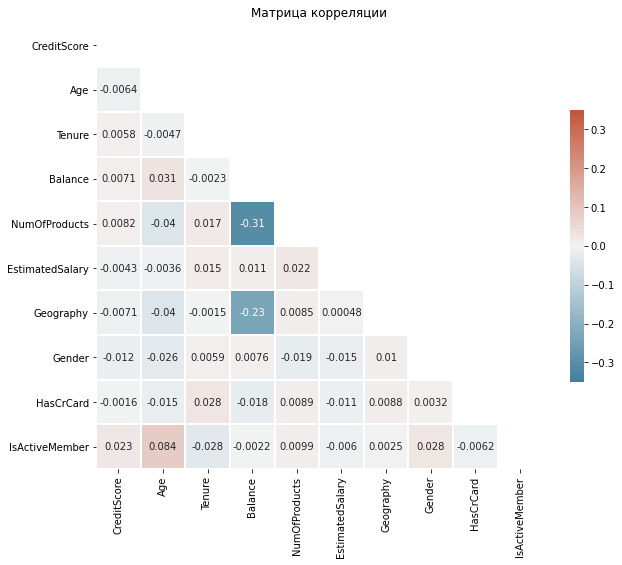

In [20]:
plot_corr_matrix(temp_df)

Сильно скоррелированных признаков нет. При этом, появилась слабая отрицательная корреляция между признаком `Geography` (после его кодирования) и признаком `Balance`.

Попробуем посчитать метрику взаимная информация (mutual information), которая показывает насколько наличие информации о значении признака сокращает неопределённость в целевом признаке. Метрика имеет нелинейную шкалу, чем выше значение метрики, тем ценнее признак.

Будем вычислять эту метрику при 2 значениях параметра `n_neighbors`: 3 и 100. Чем выше значение этого параметра, тем устойчивие оценка.

Age                0.071278
NumOfProducts      0.063552
Geography          0.019928
IsActiveMember     0.012507
Balance            0.009674
Gender             0.008961
HasCrCard          0.005631
EstimatedSalary    0.002672
CreditScore        0.000000
Tenure             0.000000
dtype: float64

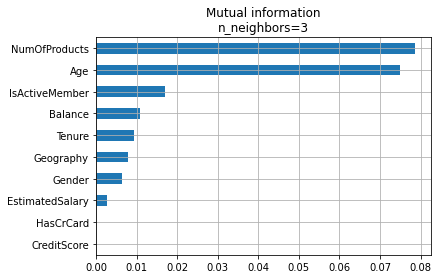

In [21]:
display(pd.Series(mutual_info_classif(temp_df, y_train), index=temp_df.columns).sort_values(ascending=False))

(pd
 .Series(mutual_info_classif(temp_df, y_train), index=temp_df.columns)
 .sort_values()
 .plot(kind='barh', grid=True, title='Mutual information\nn_neighbors=3')
)
plt.show()

Age                0.073465
NumOfProducts      0.066745
Geography          0.013822
Gender             0.008775
Balance            0.005906
IsActiveMember     0.005402
HasCrCard          0.004328
EstimatedSalary    0.002665
CreditScore        0.002433
Tenure             0.000000
dtype: float64

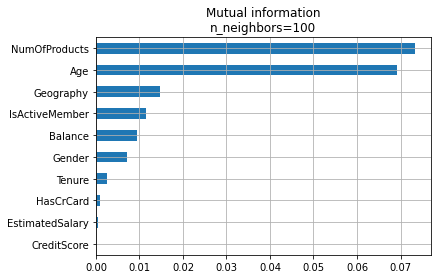

In [22]:
display(pd.Series(mutual_info_classif(temp_df, y_train), index=temp_df.columns).sort_values(ascending=False))

(pd
 .Series(mutual_info_classif(temp_df, y_train, n_neighbors=100), index=temp_df.columns)
 .sort_values()
 .plot(kind='barh', grid=True, title='Mutual information\nn_neighbors=100')
)
plt.show()

Самые низкие значения метрики имеют признаки `HasCrCard`, `EstimatedSalary`, `CreditScore`, `Tenure`. Возможно, мы буем их отбрасывать перед обучением классификатора.

### Исследование моделей без учёта дисбаланса

В целевой переменной присутствует дисбаланс классов:

In [23]:
pd.Series(y).value_counts(normalize=True).round(2)

0    0.8
1    0.2
Name: Exited, dtype: float64

Попробуем без учёта дисбаланса классов добавлять к конвейеру разные классификаторы и сравним результаты.
Рассмотрим следующие классификаторы с параметрами по умолчанию:
1. LogisticRegression;
2. SGDClassifier;
3. DecisionTreeClassifier;
4. SVC (C-Support Vector Classification);
5. RandomFrorestClassifier;
6. GradientBoostingClassifier.

In [24]:
def compare_classifiers(X, y, classifiers, methods, sampler='passthrough'):
    '''Функция для сравнения группы моделей между собой.'''
    
    for i, (classifier, method) in enumerate(zip(classifiers, methods)):
        label = type(classifier).__name__
        print(f'{i+1}. {label}')
        
        pipe = Pipeline([
            ('data_prep', col_transformer),
            ('imputer', SimpleImputer(strategy='median')),
            ('sampler', sampler),
            ('classifier', classifier)
        ])
        
        evaluate_model(model=pipe, 
                       X=X, 
                       y=y, 
                       method=method,
                       label=label
                      )
    
    print('\n')
        

1. LogisticRegression
Метрики для LogisticRegression


,mean,min,max
accuracy,0.810375,0.803750,0.820000
f1,0.280578,0.241546,0.307692
roc_auc,0.754424,0.731658,0.766683


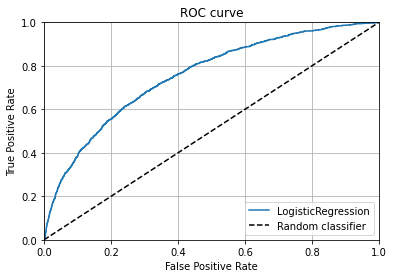

2. SGDClassifier
Метрики для SGDClassifier


,mean,min,max
accuracy,0.797500,0.796250,0.799375
f1,0.046928,0.000000,0.160622
roc_auc,0.700572,0.630529,0.728597


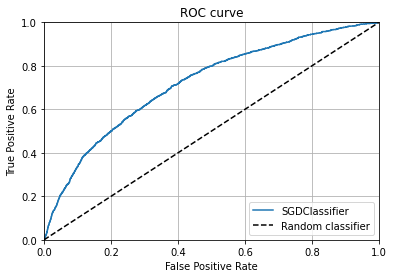

3. DecisionTreeClassifier
Метрики для DecisionTreeClassifier


,mean,min,max
accuracy,0.788750,0.777500,0.803125
f1,0.496043,0.476762,0.534125
roc_auc,0.680748,0.664696,0.705895


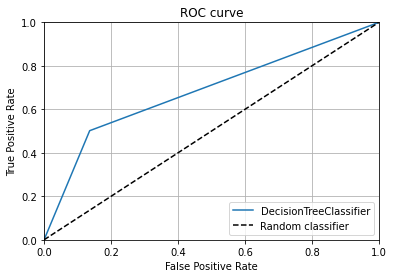

4. SVC
Метрики для SVC


,mean,min,max
accuracy,0.853125,0.845000,0.859375
f1,0.500416,0.460870,0.520661
roc_auc,0.810509,0.791642,0.827219


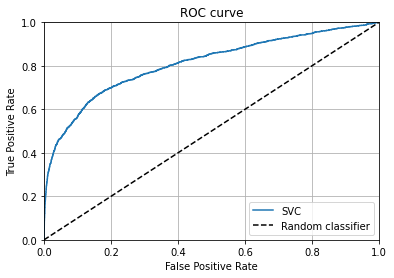

5. RandomForestClassifier
Метрики для RandomForestClassifier


,mean,min,max
accuracy,0.862000,0.851250,0.872500
f1,0.569375,0.509018,0.604288
roc_auc,0.854379,0.836513,0.866231


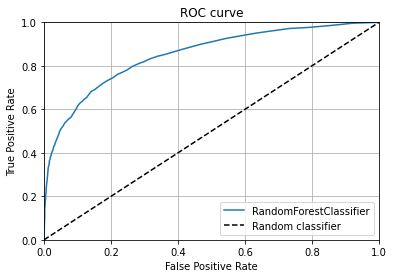

6. GradientBoostingClassifier
Метрики для GradientBoostingClassifier


,mean,min,max
accuracy,0.861625,0.851875,0.873125
f1,0.574079,0.534381,0.599606
roc_auc,0.863386,0.844694,0.878188


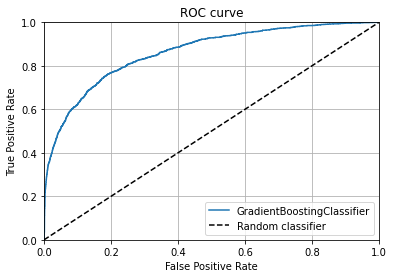

In [25]:
classifiers = [
    LogisticRegression(),
    SGDClassifier(),
    DecisionTreeClassifier(),
    SVC(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
]

methods = [
    'predict_proba',
    'decision_function',
    'predict_proba',
    'decision_function',
    'predict_proba',
    'predict_proba',
]

compare_classifiers(X=X_train, 
                    y=y_train, 
                    classifiers=classifiers, 
                    methods=methods, 
                    sampler='passthrough'
                   )

Если сравнить полученные значения метрик f1 для разных классификаторов можно заметить, что, когда дисбаланс классов никак не учитывается хуже всего себя показывают `LogisticRegression` (f1=0.28) и `SGDClassifier` (f1=0.08). В тех же условиях себя неплохо проявляет `SVC` - `C-Support Vector Classification` (f1=0.50) и классификаторы на основе деревьев:
- DecisionTreeClassifier (f1=0.49),
- RandomForestClassifier (f1=0.58),
- GradientBoostingClassifier (f1=0.57).

В целом, просматривается тенденция, что метрика roc_auc растёт вместе с метрикой f1, однако для `SGDClassifier` при очень низком значении f1=0.08, значение roc_auc=0.71.

## Борьба с дисбалансом

Как мы отметили ранее в целевом признаке присутствует дисбаланс классов. Для борьбы с ним попрбуем 3 техники:
- взвешивание классов,
- андерсемплинг,
- оверсемплинг.

Попробуем каждый приём в сочетании с разными моделями классификаторов и сравним результаты.

### Взвешивание классов
`GradientBoostingClassifier` не имеет параметра `class_weight`, и, скорее всего, не поддерживает взвешивание классов, поэтому уберём его из сравнения на данном этапе.

1. LogisticRegression
Метрики для LogisticRegression


,mean,min,max
accuracy,0.703625,0.693750,0.709375
f1,0.483308,0.463895,0.492912
roc_auc,0.759021,0.735633,0.771937


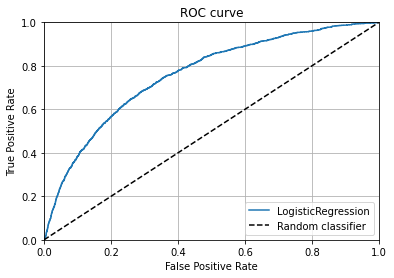

2. SGDClassifier
Метрики для SGDClassifier


,mean,min,max
accuracy,0.717625,0.677500,0.759375
f1,0.464319,0.457410,0.477912
roc_auc,0.727828,0.690962,0.752600


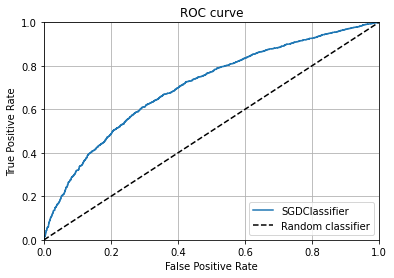

3. DecisionTreeClassifier
Метрики для DecisionTreeClassifier


,mean,min,max
accuracy,0.790500,0.780000,0.797500
f1,0.480609,0.444099,0.506747
roc_auc,0.675477,0.650287,0.694410


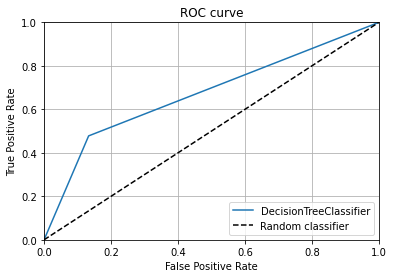

4. SVC
Метрики для SVC


,mean,min,max
accuracy,0.780625,0.773750,0.788750
f1,0.575278,0.552664,0.588942
roc_auc,0.839537,0.827580,0.847314


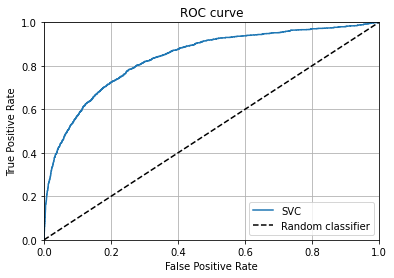

5. RandomForestClassifier
Метрики для RandomForestClassifier


,mean,min,max
accuracy,0.857500,0.848125,0.867500
f1,0.561265,0.516260,0.590818
roc_auc,0.855940,0.833376,0.869587


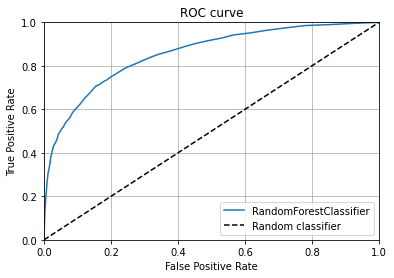

In [26]:
classifiers = [
    LogisticRegression(class_weight='balanced'),
    SGDClassifier(class_weight='balanced'),
    DecisionTreeClassifier(class_weight='balanced'),
    SVC(class_weight='balanced'),
    RandomForestClassifier(class_weight='balanced'),
]

methods = [
    'predict_proba',
    'decision_function',
    'predict_proba',
    'decision_function',
    'predict_proba',
]

compare_classifiers(X=X_train, 
                    y=y_train, 
                    classifiers=classifiers, 
                    methods=methods, 
                    sampler='passthrough'
                   )

Применение взвешивания классов позволило повысить результаты (метрику f1) всех моделей за исключением `DecisionTreeClassifier`, для которой результат практически не изменился. Взвешивание классов особенно сильно улучшило результаты `LogisticRegression` и `SGDClassifier`.

### Андерсемплинг
Попробуем реализовать андерсемплинг с помощью `imblearn.under_sampling.RandomUnderSampler`, который случайным образом выбирает представителей классов из исходного датасета.

1. LogisticRegression
Метрики для LogisticRegression


,mean,min,max
accuracy,0.703250,0.690625,0.711875
f1,0.481692,0.461371,0.491803
roc_auc,0.757041,0.734846,0.768749


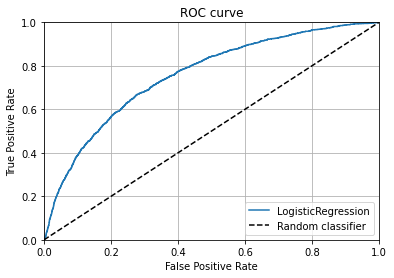

2. SGDClassifier
Метрики для SGDClassifier


,mean,min,max
accuracy,0.638875,0.547500,0.685625
f1,0.446257,0.429608,0.467532
roc_auc,0.722214,0.708950,0.734073


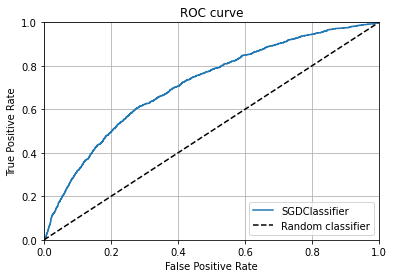

3. DecisionTreeClassifier
Метрики для DecisionTreeClassifier


,mean,min,max
accuracy,0.695875,0.676875,0.705625
f1,0.486457,0.457883,0.507135
roc_auc,0.695678,0.671199,0.709083


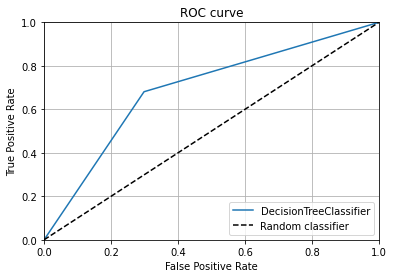

4. SVC
Метрики для SVC


,mean,min,max
accuracy,0.768625,0.751875,0.775625
f1,0.565850,0.553550,0.577778
roc_auc,0.832302,0.822180,0.843705


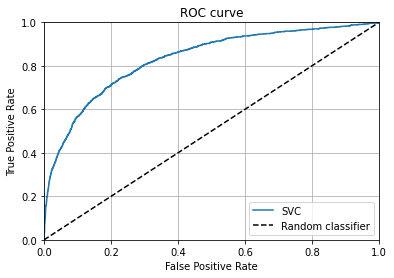

5. RandomForestClassifier
Метрики для RandomForestClassifier


,mean,min,max
accuracy,0.778875,0.768125,0.785625
f1,0.584451,0.562728,0.603819
roc_auc,0.851852,0.831263,0.861419


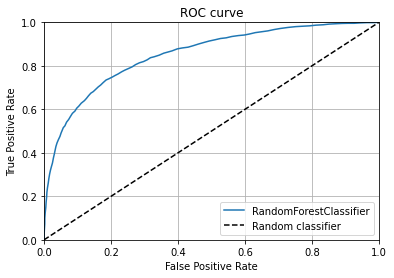

6. GradientBoostingClassifier
Метрики для GradientBoostingClassifier


,mean,min,max
accuracy,0.783000,0.770000,0.800000
f1,0.589269,0.569325,0.609547
roc_auc,0.859084,0.838390,0.869852


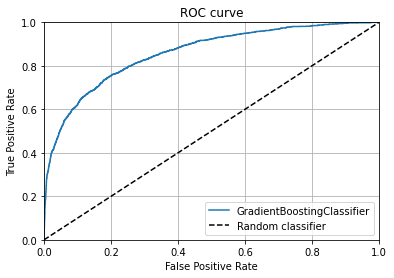

In [27]:
classifiers = [
    LogisticRegression(),
    SGDClassifier(),
    DecisionTreeClassifier(),
    SVC(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
]

methods = [
    'predict_proba',
    'decision_function',
    'predict_proba',
    'decision_function',
    'predict_proba',
    'predict_proba',
]

compare_classifiers(X=X_train, 
                    y=y_train, 
                    classifiers=classifiers, 
                    methods=methods, 
                    sampler=RandomUnderSampler(random_state=42),
                   )

Результаты чуть лучше результатов, полученных при взвешивании классов, при этом мы можем использовать `GradientBoostingClassifier`. Для `LogisticRegression` и `SGDClassifier` нет разницы между взвешиванием классов и андерсемплингом.

### Оверсемплинг

Попробуем применить оверсемплинг с `imblearn.over_sampling.SMOTE`.

1. LogisticRegression
Метрики для LogisticRegression


,mean,min,max
accuracy,0.703875,0.690625,0.707500
f1,0.480338,0.461874,0.489130
roc_auc,0.758304,0.733194,0.772361


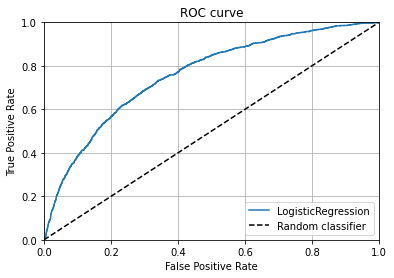

2. SGDClassifier
Метрики для SGDClassifier


,mean,min,max
accuracy,0.690500,0.596250,0.733750
f1,0.473519,0.460220,0.482204
roc_auc,0.753390,0.733755,0.768805


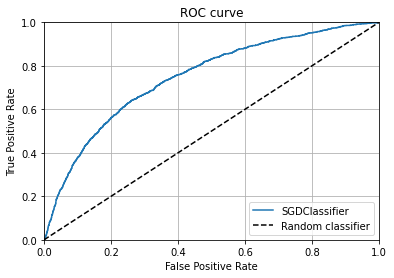

3. DecisionTreeClassifier
Метрики для DecisionTreeClassifier


,mean,min,max
accuracy,0.781875,0.771875,0.801250
f1,0.504739,0.448737,0.552822
roc_auc,0.689179,0.676361,0.701789


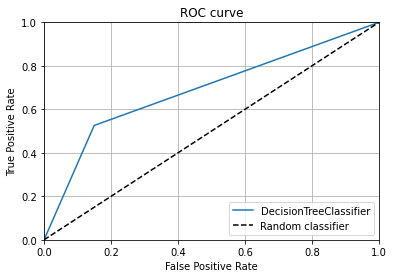

4. SVC
Метрики для SVC


,mean,min,max
accuracy,0.780250,0.768125,0.785625
f1,0.572617,0.544554,0.589806
roc_auc,0.830773,0.812739,0.839114


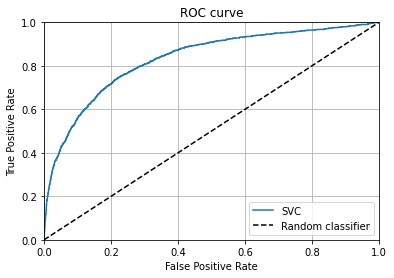

5. RandomForestClassifier
Метрики для RandomForestClassifier


,mean,min,max
accuracy,0.853125,0.841250,0.861875
f1,0.590286,0.546429,0.630282
roc_auc,0.849419,0.832440,0.860445


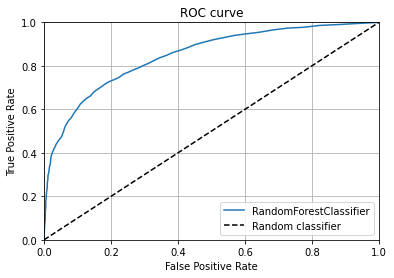

6. GradientBoostingClassifier
Метрики для GradientBoostingClassifier


,mean,min,max
accuracy,0.855750,0.842500,0.870000
f1,0.619975,0.571429,0.643333
roc_auc,0.859404,0.841521,0.871090


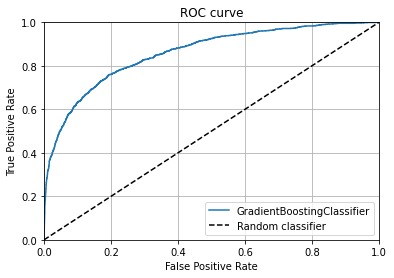

In [28]:
classifiers = [
    LogisticRegression(),
    SGDClassifier(),
    DecisionTreeClassifier(),
    SVC(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
]

methods = [
    'predict_proba',
    'decision_function',
    'predict_proba',
    'decision_function',
    'predict_proba',
    'predict_proba',
]

compare_classifiers(X=X_train, 
                    y=y_train, 
                    classifiers=classifiers, 
                    methods=methods, 
                    sampler=SMOTE(),
                   )

Модели с оверсемплингом показали результаты близкие к результатом моделей с андерсемплингом, однако рекорд поставил `GradientBoostingClassifier` в сочетании с оверсемплингом (f1=0.62, roc_auc=0.86), поэтому остановимся именно на таком сочетании.

## Лучшая модель

Опишем конвейер модели, показавшей лучшие результаты.

In [29]:
pipeline = Pipeline([
    ('data_prep', col_transformer),
    ('imputer', SimpleImputer(strategy='median')),
    ('oversampler', SMOTE()),
    ('feature_selection', 'passthrough'),
    ('classifier', GradientBoostingClassifier())
])

pipeline

Pipeline(steps=[('data_prep',
                 ColumnTransformer(transformers=[('drop', 'drop',
                                                  ['Surname', 'RowNumber',
                                                   'CustomerId']),
                                                 ('numerical', StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary']),
                                                 ('categorical',
                                                  CountEncoder(combine_min_nan_groups=True,
                                                               normalize=True),
                                                  ['Geography', 'Gender',
                                                   'HasCrCard',
                     

В конвейер был добавлен шаг `feature_selection`, чтобы при подборе гиперпараметров попробовать оставлять этот шаг пустым или отбрасывать на нём часть признаков с низкими значениями метрики `mutual_information`.

## Подбор гиперпараметров

Подберём гиперпараметры с помощью `GridSearchCV`.

In [30]:
param_grid = {'feature_selection': ['passthrough', SelectKBest(score_func=mutual_info_classif, k=5)],
              'classifier__learning_rate': [0.05, 0.1, 0.2],
              'classifier__n_estimators': [50, 100, 150],
              'classifier__min_samples_split': [100, 150, 200],
              'classifier__max_depth': [3, 10, 20],
             }



grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='f1',
                           return_train_score=True,
                           cv=5,
                           n_jobs=-1,
                           verbose=2,
                          )

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

grid_search.best_params_

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END classifier__learning_rate=0.05, classifier__max_depth=3, classifier__min_samples_split=100, classifier__n_estimators=50, feature_selection=passthrough; total time=   0.8s
[CV] END classifier__learning_rate=0.05, classifier__max_depth=3, classifier__min_samples_split=100, classifier__n_estimators=50, feature_selection=passthrough; total time=   0.8s
[CV] END classifier__learning_rate=0.05, classifier__max_depth=3, classifier__min_samples_split=100, classifier__n_estimators=50, feature_selection=passthrough; total time=   0.8s
[CV] END classifier__learning_rate=0.05, classifier__max_depth=3, classifier__min_samples_split=100, classifier__n_estimators=50, feature_selection=passthrough; total time=   0.8s
[CV] END classifier__learning_rate=0.05, classifier__max_depth=3, classifier__min_samples_split=100, classifier__n_estimators=50, feature_selection=passthrough; total time=   0.8s
[CV] END classifier__learning_rate=0.

{'classifier__learning_rate': 0.1,
 'classifier__max_depth': 3,
 'classifier__min_samples_split': 100,
 'classifier__n_estimators': 100,
 'feature_selection': 'passthrough'}

Метрики для best_model


,mean,min,max
accuracy,0.854625,0.838125,0.868125
f1,0.620808,0.575251,0.647841
roc_auc,0.860747,0.841087,0.873854


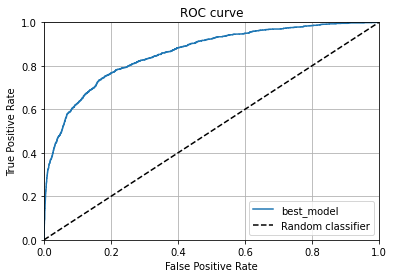

In [31]:
evaluate_model(model=best_model, X=X_train, y=y_train, label='best_model')

Победил конвейер, использующий все признаки. Его параметры и результаты, показанные моделью, приведены выше.

Результаты удалось немного улучшить. Проверим данную модель на тестовой выборке.

## Тестирование модели

Accuracy: 0.86
F1 score: 0.63
ROC AUC: 0.76


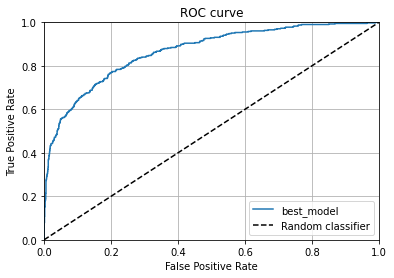

In [32]:
def check_on_test(model, X, y, label):
    '''Вычисляет и выводит на экран сводку опроизводительности модели на 
    тестовом наборе аналогично функции evaluate_model'''
    y_pred = model.predict(X)
    
    print(f'Accuracy: {accuracy_score(y, y_pred):.2f}')
    print(f'F1 score: {f1_score(y, y_pred):.2f}')
    print(f'ROC AUC: {roc_auc_score(y, y_pred):.2f}')
    
    y_scores = model.predict_proba(X)[:, -1]
    
    plot_roc_curve(y, y_scores, label=label)
    plt.show()
    
    
check_on_test(model=best_model, X=X_test, y=y_test, label='best_model')

Сравним полученные результаты с результатами базовой модели

Accuracy: 0.67
F1 score: 0.19
ROC AUC: 0.49


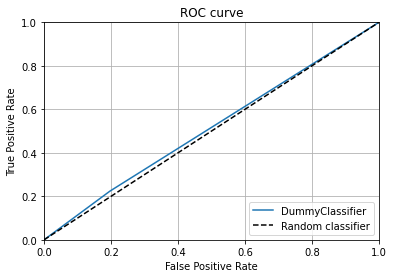

In [33]:
check_on_test(model=dummy_clf.fit(X_train, y_train), X=X_test, y=y_test, label='DummyClassifier')

Результаты лучшей модели значительно выше, чем результаты базовой. Желаемое значение целевой метрики достигнуто.

## Вывод

Метрика **roc_auc** имеет свойство расти вместе с метрикой **f1**, при этом целесообразно использовать их в паре.

Дисбаланс классов в целевой переменной может существенно влиять на качество предсказаний классификаторов, поэтому необходимо предпринимать метры борьбы с дисбалансом:
- взвешивание классов,
- андерсемплинг,
- апсемплинг.

Андерсемплинг и апсемплинг показывали примерно одинаковые результаты, но лучшей оказалась модель сочетающая апсемплинг и `GradientBoostingClassifier`.

Подбор гиперпараметров позволил увеличить значения целевой метрики. Лучшие результаты показал следующий конвейер:
```Python
best_model= Pipeline([
    ('data_prep', col_transformer),
    ('imputer', SimpleImputer(strategy='median')),
    ('oversampler', SMOTE()),
    ('classifier', GradientBoostingClassifier(learning_rate=0.1,
                                              max_depth=3,
                                              min_samples_split=200,
                                              n_estimators=100,
                                             )
    )
])
```

Результаты лучшей модели значительно выше, чем результаты базовой. Желаемое значение целевой метрики достигнуто.